<a href="https://colab.research.google.com/github/Ahmed-Magdi1/2DOF-Helicopter-NARX/blob/main/NARX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Important libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

In [4]:
# Load input and output CSV files
inputs = pd.read_csv('inputs.csv')  # Contains: V, I_pitch, I_yaw
outputs = pd.read_csv('outputs.csv')  # Contains: pitch_angle, yaw_angle

# Convert to arrays
X = inputs.values  # Shape: (samples, features)
Y = outputs.values  # Shape: (samples, targets)

##Normalize the Data

In [5]:
# Create scalers for inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Fit and transform the data
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

##Lagged Features

In [6]:
def create_lagged_data(inputs, outputs, input_lag, output_lag):
    X_lagged, Y_lagged = [], []
    for t in range(max(input_lag, output_lag), len(inputs)):
        x_lagged = inputs[t-input_lag:t].flatten()  # Lagged inputs
        y_lagged = outputs[t-output_lag:t-1].flatten()  # Lagged outputs
        X_lagged.append(np.hstack((x_lagged, y_lagged)))  # Combine input-output lags
        Y_lagged.append(outputs[t])  # Current output
    return np.array(X_lagged), np.array(Y_lagged)

##Lagged Data

In [7]:
# Define input and output lags
input_lag = 3  # Number of past input time steps to use
output_lag = 2  # Number of past output time steps to use

# Generate lagged data
X_lagged, Y_lagged = create_lagged_data(X_scaled, Y_scaled, input_lag, output_lag)

# Split the lagged data
X_train, X_test, Y_train, Y_test = train_test_split(X_lagged, Y_lagged, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

##Define the Feedforward Neural Network

In [25]:
# Define the NARX neural network
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),  # Input: lagged features
    Dense(128, activation='relu'),
    Dense(Y_train.shape[1], activation='linear')  # Output: pitch and yaw angles
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,346 (36.51 KB)

 Trainable params: 9,346 (36.51 KB)

 Non-trainable params: 0 (0.00 B)

##Train the Model

In [26]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2859 - mae: 0.4450 - val_loss: 0.0581 - val_mae: 0.1864
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0333 - mae: 0.1387 - val_loss: 0.0163 - val_mae: 0.0848
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - mae: 0.0694 - val_loss: 0.0074 - val_mae: 0.0469
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0386 - val_loss: 0.0055 - val_mae: 0.0330
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0321 - val_loss: 0.0054 - val_mae: 0.0314
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mae: 0.0283 - val_loss: 0.0053 - val_mae: 0.0295
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mae: 0.0254 - val_loss: 0.0052 - val_mae: 0.0272
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0229 - val_loss: 0.0052 - val_mae: 0.0280
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae:

##Evaluate the Model

In [27]:
loss, mae = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - mae: 0.0218     
Test Loss: 0.0025302800349891186, Test MAE: 0.021846789866685867


##Predictions

In [28]:
# Predict on test set
Y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual outputs
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_actual = scaler_Y.inverse_transform(Y_test)

# Compare predictions and actual values

# Create a comparison DataFrame
comparison = pd.DataFrame({
    'Predicted Pitch': Y_pred[:, 0],
    'Actual Pitch': Y_actual[:, 0],
    'Predicted Yaw': Y_pred[:, 1],
    'Actual Yaw': Y_actual[:, 1]
})

# Print the first 30 rows of the comparison
print(comparison.head(30))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
    Predicted Pitch  Actual Pitch  Predicted Yaw  Actual Yaw
0         56.526569         57.25      -2.827332       -2.25
1         56.561230         57.50       2.227990        2.25
2         62.426453         64.25       7.311347        7.50
3         60.109848         62.00      -0.683243       -0.50
4         61.075256         61.25      -6.413398       -6.50
5         57.278591         59.00     -12.153296      -12.75
6         57.834057         57.50       2.199217        2.25
7         60.791977         62.00      -1.000883       -0.75
8         57.717499         57.50       1.883516        2.25
9         57.817989         59.00      -5.891702       -5.50
10        -0.536305         -0.25       5.302520        5.75
11        40.324490         36.00      -7.441886       -7.00
12        61.040562         61.25       3.542969        3.50
13        56.731487         57.25       2.917114        2.25
14        55.829578         59.25     -10.43422

##Visualize Results

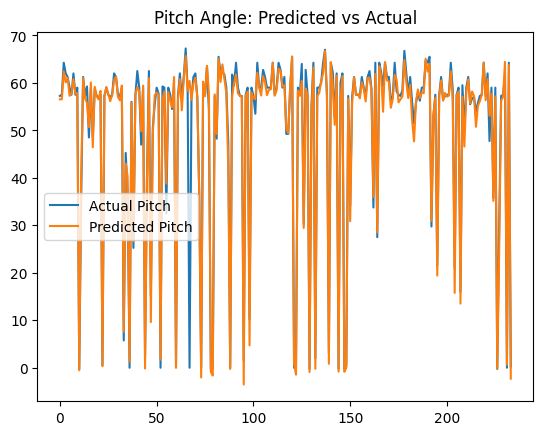

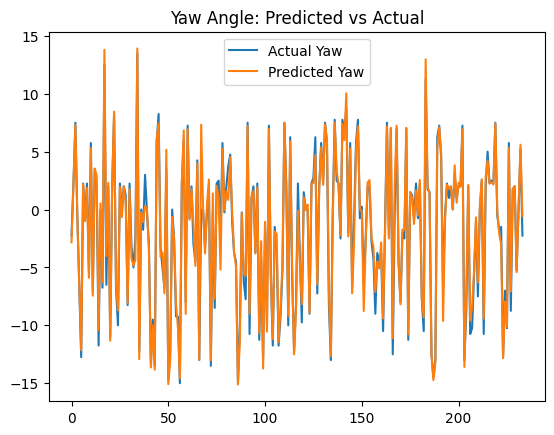

In [29]:
# Plot pitch predictions
plt.figure()
plt.plot(Y_actual[:, 0], label='Actual Pitch')
plt.plot(Y_pred[:, 0], label='Predicted Pitch')
plt.legend()
plt.title('Pitch Angle: Predicted vs Actual')
plt.show()

# Plot yaw predictions
plt.figure()
plt.plot(Y_actual[:, 1], label='Actual Yaw')
plt.plot(Y_pred[:, 1], label='Predicted Yaw')
plt.legend()
plt.title('Yaw Angle: Predicted vs Actual')
plt.show()

In [30]:
# Calculate MAE
mae_pitch = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
mae_yaw = mean_absolute_error(Y_actual[:, 1], Y_pred[:, 1])

# Calculate RMSE
rmse_pitch = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
rmse_yaw = np.sqrt(mean_squared_error(Y_actual[:, 1], Y_pred[:, 1]))

# Print metrics
print(f"Pitch MAE: {mae_pitch}, Pitch RMSE: {rmse_pitch}")
print(f"Yaw MAE: {mae_yaw}, Yaw RMSE: {rmse_yaw}")

Pitch MAE: 1.5482429531661586, Pitch RMSE: 4.342401754542226
Yaw MAE: 0.6380175840523508, Yaw RMSE: 0.9764340655341918


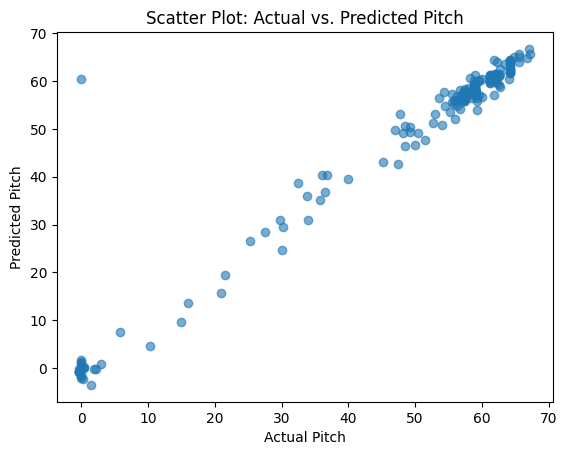

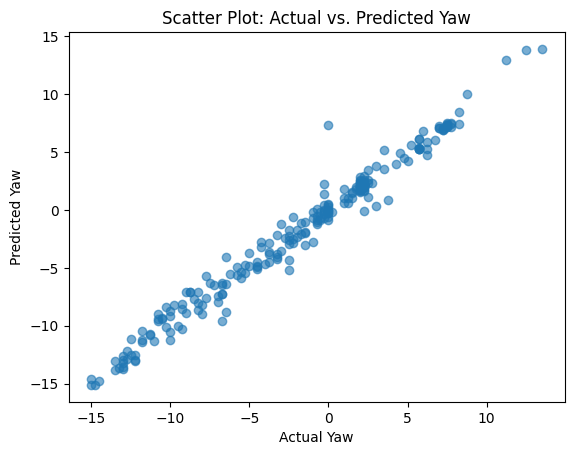

In [31]:
# Scatter plot for Pitch
plt.figure()
plt.scatter(Y_actual[:, 0], Y_pred[:, 0], alpha=0.6)
plt.xlabel('Actual Pitch')
plt.ylabel('Predicted Pitch')
plt.title('Scatter Plot: Actual vs. Predicted Pitch')
plt.show()

# Scatter plot for Yaw
plt.figure()
plt.scatter(Y_actual[:, 1], Y_pred[:, 1], alpha=0.6)
plt.xlabel('Actual Yaw')
plt.ylabel('Predicted Yaw')
plt.title('Scatter Plot: Actual vs. Predicted Yaw')
plt.show()

In [32]:
# Compile the model with full names for loss and metrics
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Save the model
model.save('narx_helicopter_model.h5')
print("Model saved successfully.")

Model saved successfully.


In [36]:
model = load_model('narx_helicopter_model.h5')
print("Model loaded successfully.")

Model loaded successfully.
